In [2]:
%pip install tensorflow scikit-image matplotlib numpy scikit-learn segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00


In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import os
import segmentation_models as sm

os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, filters, morphology, transform
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import glob
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import json
from segmentation_models.losses import DiceLoss, BinaryCELoss
from segmentation_models.metrics import IOUScore, FScore

In [24]:
image_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/"
model_dir = "/content/drive/MyDrive/LXthon"
test_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/test_dataset_mc/eye_test/1000.png"
answer_dir = "/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/test_ground_truth/eye_mask/1000.png"
#mask_dir = "Data/train/mask"
#test_image_path = "Data/test/image/0.png"
#test_image_dir = "Data/test/image"
#test_mask_dir = "Data/test/mask"

In [9]:
def convert_folder_to_masks(
        image_dir,
        mask_suffix="_mask.png",
        masks_subfolder="masks",
        output_dir=None
    ):
    """
    For every .png in image_dir, looks for a same-named .geojson,
    rasterizes its polygons into an 8-bit binary mask (0 background, 255 vessels),
    and saves it as <basename>_mask.png.
    Tries to create a 'masks' subfolder inside image_dir (or uses output_dir if provided).
    Falls back to local './masks' if target is not writable.
    Handles Polygon and MultiPolygon geometries; casts coords to ints.

    Supports GeoJSON with a top-level dict {{ 'features': [...] }} or a list of features directly.
    """
    # Determine masks directory
    if output_dir:
        masks_dir = output_dir
    else:
        masks_dir = os.path.join(image_dir, masks_subfolder)

    # Attempt to create masks directory, fall back if necessary
    try:
        os.makedirs(masks_dir, exist_ok=True)
    except OSError as e:
        print(f"⚠️ Cannot create {masks_dir} ({e}), falling back to './{masks_subfolder}'")
        masks_dir = os.path.abspath(masks_subfolder)
        os.makedirs(masks_dir, exist_ok=True)

    print(f"Saving masks into: {masks_dir}")

    for fname in os.listdir(image_dir):
        if not fname.lower().endswith('.png'):
            continue

        base, _ = os.path.splitext(fname)
        img_path = os.path.join(image_dir, fname)
        geo_path = os.path.join(image_dir, base + '.geojson')
        mask_path = os.path.join(masks_dir, base + mask_suffix)

        if not os.path.exists(geo_path):
            print(f"→ skipping {fname}: no {base}.geojson found")
            continue

        # Load image for size
        img = Image.open(img_path)
        w, h = img.size

        # Prepare blank mask (8-bit)
        mask = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask)

        # Load annotations
        with open(geo_path, 'r') as f:
            gj = json.load(f)

        # Extract feature list, support dict or list
        if isinstance(gj, dict) and 'features' in gj:
            features = gj['features']
        elif isinstance(gj, list):
            features = gj
        else:
            print(f"→ warning: unexpected GeoJSON format in {geo_path}")
            continue

        # Draw each polygon using white (255)
        for feat in features:
            geom = feat.get('geometry') if isinstance(feat, dict) else None
            if not geom:
                continue
            geom_type = geom.get('type')
            coords = geom.get('coordinates', [])

            def draw_poly(rings):
                for ring in rings:
                    pts = [(int(round(x)), int(round(y))) for x, y in ring]
                    if len(pts) >= 3:
                        draw.polygon(pts, outline=255, fill=255)

            if geom_type == 'Polygon':
                draw_poly(coords)
            elif geom_type == 'MultiPolygon':
                for poly in coords:
                    draw_poly(poly)
            else:
                print(f"→ warning: unsupported geometry type {geom_type} in {geo_path}")

        # Save mask (pixels 0 or 255 now visible)
        mask.save(mask_path)
        print(f"✓ wrote mask: {mask_path}")


In [10]:
convert_folder_to_masks(image_dir)

⚠️ Cannot create /content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/masks ([Errno 30] Read-only file system: '/content/drive/MyDrive/LXTHON EYE CHALLENGE FILES/train_dataset_mc/masks'), falling back to './masks'
Saving masks into: /content/masks
✓ wrote mask: /content/masks/164_mask.png
✓ wrote mask: /content/masks/157_mask.png
✓ wrote mask: /content/masks/182_mask.png
✓ wrote mask: /content/masks/163_mask.png
✓ wrote mask: /content/masks/159_mask.png
✓ wrote mask: /content/masks/187_mask.png
✓ wrote mask: /content/masks/173_mask.png
✓ wrote mask: /content/masks/219_mask.png
✓ wrote mask: /content/masks/225_mask.png
✓ wrote mask: /content/masks/212_mask.png
✓ wrote mask: /content/masks/218_mask.png
✓ wrote mask: /content/masks/216_mask.png
✓ wrote mask: /content/masks/194_mask.png
✓ wrote mask: /content/masks/220_mask.png
✓ wrote mask: /content/masks/211_mask.png
✓ wrote mask: /content/masks/223_mask.png
✓ wrote mask: /content/masks/222_mask.png
✓ wrote mask: /content/m

In [11]:
mask_dir = "/content/masks/"

In [12]:
def load_data(
    image_dir,
    masks_subfolder='masks',
    mask_suffix='_mask.png',
    input_shape=(256,256,3)
):
    """
    Loads images and masks from disk, resizes them to input_shape,
    and returns NumPy arrays ready for training.

    Args:
        image_dir: path containing image .png files
        masks_subfolder: subfolder under image_dir where masks live
        mask_suffix: suffix added to image basename for masks
        input_shape: (H, W, C) target size and channels (3 for RGB)

    Returns:
        X: np.ndarray, shape (N, H, W, C), dtype float32, values [0,1]
        y: np.ndarray, shape (N, H, W, 1), dtype float32, values [0,1]
    """
    H, W, C = input_shape
    imgs, msks = [], []
    masks_dir = os.path.join(image_dir, masks_subfolder)

    for fname in sorted(os.listdir(image_dir)):
        if not fname.lower().endswith('.png'):
            continue
        base, _ = os.path.splitext(fname)

        img_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(masks_dir, base + mask_suffix)
        if not os.path.exists(mask_path):
            print(f"→ warning: mask missing for {fname}, skipping")
            continue

        # Load and resize image
        img = Image.open(img_path).convert('RGB')
        img = img.resize((W, H), Image.BILINEAR)
        img_np = np.array(img, dtype=np.float32) / 255.0

        # Load and resize mask
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize((W, H), Image.NEAREST)
        mask_np = np.array(mask, dtype=np.float32) / 255.0
        mask_np = mask_np[..., None]

        imgs.append(img_np)
        msks.append(mask_np)

    X = np.stack(imgs, axis=0)
    y = np.stack(msks, axis=0)
    return X, y

In [13]:
X, y = load_data(image_dir, mask_dir)

→ warning: mask missing for 176.png, skipping
→ warning: mask missing for 202 .png, skipping
→ warning: mask missing for 233.png, skipping
→ warning: mask missing for 248 .png, skipping
→ warning: mask missing for 257.png, skipping
→ warning: mask missing for 377.png, skipping
→ warning: mask missing for 379.png, skipping
→ warning: mask missing for 391.png, skipping
→ warning: mask missing for 419.png, skipping
→ warning: mask missing for 442.png, skipping
→ warning: mask missing for 448.png, skipping
→ warning: mask missing for 622.png, skipping
→ warning: mask missing for 647.png, skipping
→ warning: mask missing for 683.png, skipping


In [14]:
print(f"Training data shape: X={X.shape}, y={y.shape}")

Training data shape: X=(641, 256, 256, 3), y=(641, 256, 256, 1)


In [15]:
def build_unet(input_shape=(256, 256, 3), backbone='resnet34'):
    """
    Builds a U-Net model with a pre-trained ImageNet encoder.

    Args:
        input_shape: tuple, (H, W, C)
        backbone: string, name of the encoder (e.g. 'resnet34', 'efficientnetb0')

    Returns:
        A compiled tf.keras.Model
    """
    # Instantiate model
    model = sm.Unet(
        backbone,
        encoder_weights='imagenet',
        input_shape=input_shape,
        classes=1,
        activation='sigmoid',
    )

    # Loss and metrics
    dice_loss = sm.losses.DiceLoss()
    bce_loss  = sm.losses.BinaryCELoss()
    total_loss = dice_loss + bce_loss

    metrics = [
        sm.metrics.IOUScore(threshold=0.5),
        sm.metrics.FScore(threshold=0.5),
    ]

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=total_loss,
        metrics=metrics,
    )
    return model

In [16]:
model = build_unet((256, 256, 3))

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
total_loss = DiceLoss() + BinaryCELoss()

model.compile(
    optimizer='adam',
    loss=total_loss,
    metrics=[IOUScore(threshold=0.5), FScore(threshold=0.5)]
)


callbacks = [
    ModelCheckpoint('best_unet_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True),
]

history = model.fit(
  X, y,
  validation_split=0.2,
  batch_size=8,
  epochs=100,
  callbacks=callbacks,
  verbose=1
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 144ms/step - f1-score: 0.3811 - iou_score: 0.2363 - loss: 0.7297 - val_f1-score: 1.8546e-09 - val_iou_score: 1.8546e-09 - val_loss: 1.0724
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - f1-score: 0.4292 - iou_score: 0.2740 - loss: 0.6542 - val_f1-score: 1.8546e-09 - val_iou_score: 1.8546e-09 - val_loss: 1.1252
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1-score: 0.4532 - iou_score: 0.2938 - loss: 0.6268 - val_f1-score: 1.8546e-09 - val_iou_score: 1.8546e-09 - val_loss: 1.1360
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1-score: 0.4553 - iou_score: 0.2960 - loss: 0.6253 - val_f1-score: 1.8546e-09 - val_iou_score: 1.8546e-09 - val_loss: 1.1493
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1-score: 0.4692 - iou_score: 0.3076 - loss: 0.6118 - val_f1-score: 1.8546e-09 - val_iou_score: 1.8546e-09 - val_loss: 1.1362
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1-score: 0.4793 - iou_score: 0.3171 - loss:

In [19]:
def plot_metrics(history):
    """
    Plots loss and metrics from a Keras History object.

    Args:
        history: tf.keras.callbacks.History returned by model.fit()
    """
    # Extract history dict
    h = history.history

    # Plot Loss
    plt.figure()
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot each metric
    for key in h:
        if key in ('loss', 'val_loss'):
            continue
        plt.figure()
        plt.plot(h[key], label=f'train_{key}')
        val_key = 'val_' + key if not key.startswith('val_') else key
        if val_key in h:
            plt.plot(h[val_key], label=val_key)
        plt.title(f'{key} Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(key)
        plt.legend()
        plt.show()

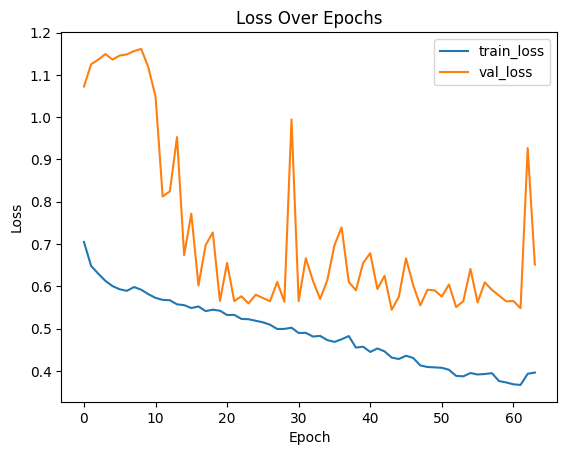

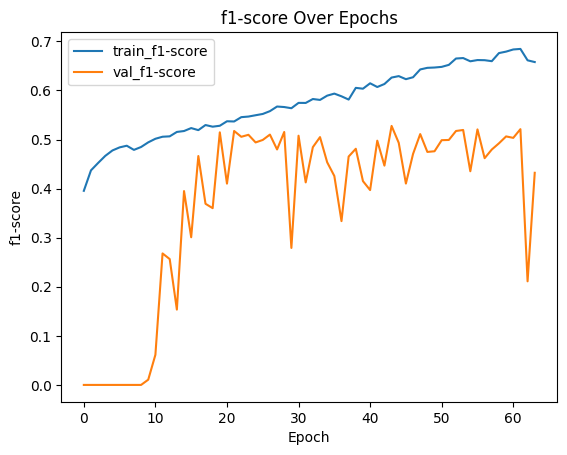

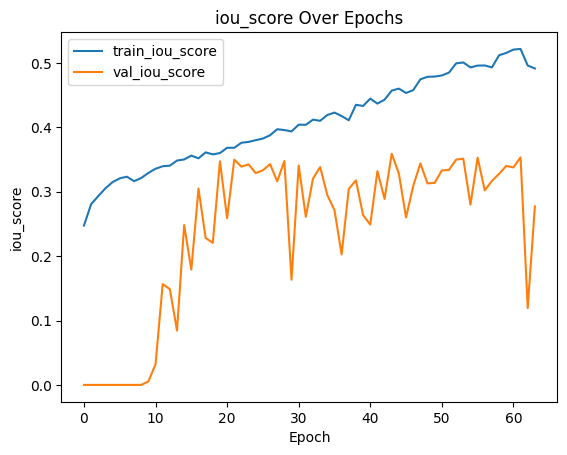

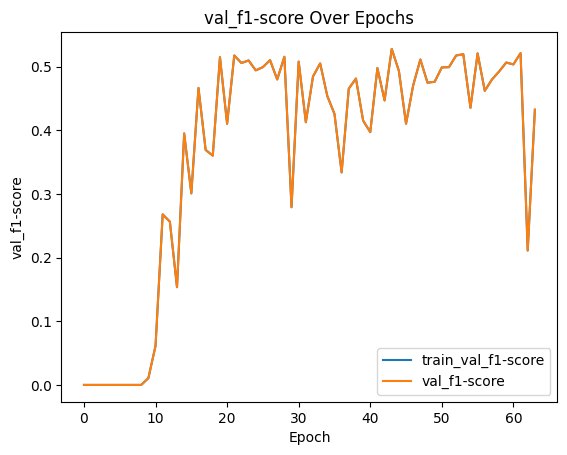

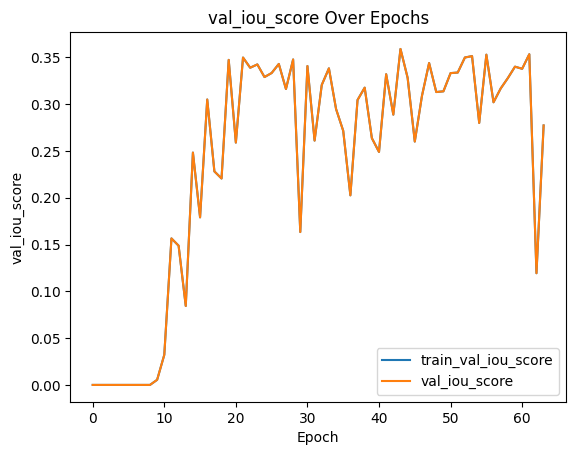

In [20]:
plot_metrics(history)

In [25]:
model.save(os.path.join(model_dir, 'best_unet_model.keras'))